## Deep ConvNet hand gesture regconition using Tensorflow

In [1]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
import math
import time
import cv2
from IPython.display import Image

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

print('Training x set:', X_train_orig.shape)
print('Training y set:', Y_train_orig.shape)
print('Test x set:', X_test_orig.shape)
print('Test y set:', Y_test_orig.shape)
print('Classes: ', classes)

Training x set: (1080, 64, 64, 3)
Training y set: (1, 1080)
Test x set: (120, 64, 64, 3)
Test y set: (1, 120)
Classes:  [0 1 2 3 4 5]


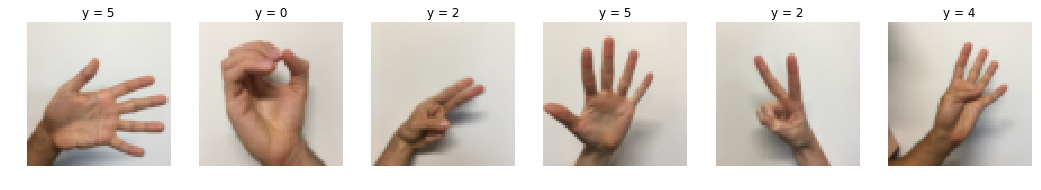

In [120]:
# display images
plt.figure(figsize=(18,18))
for i in range(6):
    img = X_train_orig[i]
    plt.subplot(1,6,i+1)
    plt.imshow(img)
    plt.title('y = ' + str(np.squeeze(Y_train_orig[:,i])))
    plt.axis('off')
plt.show()

In [4]:
# normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.ravel()].T
    return Y

# One hot encoding the labels (length = number of classes)
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [14]:
def create_placeholders(h, w, c, num_classes, name='placeholders'):
    with tf.name_scope(name):
        X = tf.placeholder(tf.float32, [None, h, w, c], name='X')
        Y = tf.placeholder(tf.float32, [None, num_classes], name='Y')
        keep_prop = tf.placeholder_with_default(1.0, shape=(), name='keep_prop')
        return X, Y, keep_prop

In [5]:
def initialize_parameters(name='parameters'):   
    with tf.variable_scope(name):
        tf.set_random_seed(1)        
        W1 = tf.get_variable("W1", shape=[4,4,3,8], dtype=tf.float32, initializer=tf.truncated_normal_initializer())
        W2 = tf.get_variable("W2", shape=[2,2,8,16], dtype=tf.float32, initializer=tf.truncated_normal_initializer())        
        '''
        W3 = tf.get_variable("W3", shape=[16*16*16, 1024], dtype=tf.float32, initializer=tf.truncated_normal_initializer()) 
        W4 = tf.get_variable("W4", shape=[1024, 120], dtype=tf.float32, initializer=tf.truncated_normal_initializer())
        W5 = tf.get_variable("W5", shape=[120, 84], dtype=tf.float32, initializer=tf.truncated_normal_initializer())
        W6 = tf.get_variable("W6", shape=[84, 6], dtype=tf.float32, initializer=tf.truncated_normal_initializer())
        '''
        parameters = {"W1": W1, "W2": W2}
        return parameters

In [6]:
def conv_layer(input_data, kernel, name='conv'):
    with tf.name_scope(name):
        conv = tf.nn.conv2d(input_data, kernel, strides=[1,1,1,1], padding='SAME', name=name)
        return conv
    
def relu_layer(input_data, name='relu'):
    with tf.name_scope(name):
        relu = tf.nn.relu(input_data, name=name)
        return relu

def pooling_layer(input_data, filter_size, stride, name='pool'):
    with tf.name_scope(name):
        pool = tf.nn.max_pool(input_data, [1,filter_size,filter_size,1], 
                              [1,stride,stride,1], padding='SAME', name=name)
        return pool

def dropout_layer(input_data, p, name='dropout'):
    with tf.name_scope(name):
        dropout = tf.nn.dropout(input_data, keep_prob=p, name=name)
        return dropout

def fc_layer(input_data, size, name='fc'):
    with tf.name_scope(name):
        fc = tf.layers.dense(inputs=input_data, units=size, activation=tf.nn.relu, name=name)
        #fc = tf.nn.relu(tf.matmul(input_data, w), name=name)
        return fc
        
    
# forward propagation
def forward_propagation(X, parameters, keep_prop, name='forward'):    
    with tf.name_scope(name):
        W1 = parameters['W1']
        W2 = parameters['W2'] 
        '''
        W3 = parameters['W3']
        W4 = parameters['W4']
        W5 = parameters['W5']
        W6 = parameters['W6']
        '''
        conv1 = conv_layer(X, W1, 'conv1')            
        relu1 = relu_layer(conv1, 'relu1')            
        pool1 = pooling_layer(relu1, 2, 2, 'pool1')   
        conv2 = conv_layer(pool1, W2, 'conv2')        
        relu2 = relu_layer(conv2, 'relu2')            
        pool2 = pooling_layer(relu2, 2, 2, 'pool2')            
        flatten = tf.reshape(pool2, [-1, 16*16*16], name='flatten')    
                                      
        dropout = dropout_layer(flatten, keep_prop, 'dropout')
        fc = tf.layers.dense(inputs=dropout, units=6, activation=None, name='fc')
        return fc

In [7]:
# possibly include L2 regularization
def compute_loss_regularize(fc, Y, parameters, lamb=0.0, name='loss'):  
    with tf.variable_scope(name) as scope:
        W1 = parameters['W1']
        W2 = parameters['W2'] 
        '''
        W3 = parameters['W3']
        W4 = parameters['W4']
        W5 = parameters['W5']
        W6 = parameters['W6']
        '''
        entropy = tf.nn.softmax_cross_entropy_with_logits(logits = fc, labels = Y)        
        regularization = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)                          
        loss = tf.reduce_mean(entropy + lamb*regularization, name=scope.name)       
        return loss

In [8]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):   
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [9]:
# define model
def define_model(lamb=0.0, learning_rate=0.001):
    ops.reset_default_graph()        # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)
    
     # define input data and compute loss function
    X, Y, keep_prop = create_placeholders(X_train.shape[1], X_train.shape[2], X_train.shape[3], Y_train.shape[1])
    parameters = initialize_parameters()
    fc = forward_propagation(X, parameters, keep_prop)
    loss = compute_loss_regularize(fc, Y, parameters, lamb) 
    
    # optimizer     
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    # Calculate the correct predictions
    sm = tf.nn.softmax(fc)
    predict_op = tf.argmax(sm, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

    # Calculate accuracy on the train and test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    # model
    model = {
        'X': X,
        'Y': Y,
        'keep_prop': keep_prop,
        'parameters': parameters,
        'fc': fc,
        'loss': loss,
        'optimizer': optimizer,
        'num_corrects': tf.reduce_sum(tf.cast(correct_prediction, "int32")),
        'accuracy': accuracy
    }   
        
    return model

In [10]:
# train model
def train_model(model, num_epochs, minibatch_size=64, dropout_rate=1.0):
    # get model
    X = model['X']
    Y = model['Y']
    keep_prop = model['keep_prop']
    params = model['parameters']
    fc = model['fc']
    loss = model['loss']
    optimizer = model['optimizer']
    num_corrects = model['num_corrects']
    accuracy = model['accuracy']
    
    seed = 0
    
    # to find best trained model
    train_best_acc = 0.0
    test_best_acc = 0.0
    test_best_fc = None
    
    # create a summray to put into the event file
    with tf.name_scope('summaries'):
        tf.summary.scalar('loss', loss)
        tf.summary.scalar('accuracy', accuracy)
        tf.summary.histogram('histogram_loss', loss)
        tf.summary.histogram('histogram_accuracy', accuracy)
        summary_op = tf.summary.merge_all()
    
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    
    # train
    with tf.Session() as sess:
        sess.run(init)
        start_time = time.time()
        saver = tf.train.Saver()      # to save trained model
        
        # To visualize Tensorboard
        writer_train = tf.summary.FileWriter('signs_curve/plot_train')    
        writer_test = tf.summary.FileWriter('signs_curve/plot_test')
        writer_graph = tf.summary.FileWriter('signs_graph')
        writer_graph.add_graph(sess.graph)
        
        num_minibatches = int(X_train.shape[0]/minibatch_size)     # number of minibatches
        
        # iterate through each epoch
        for epoch in range(num_epochs):
            seed += 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            train_running_loss = 0.0             
            train_total_corrects = 0                         
            
            # minibatch GD
            for batch in minibatches:                                
                # start training
                (batch_x, batch_y) = batch                
                _, _, train_loss, train_acc, train_ncorrects, summary_train = sess.run([optimizer, fc, loss, accuracy, num_corrects, summary_op], 
                                                                          feed_dict={X: batch_x, Y: batch_y, keep_prop: dropout_rate}) 
                train_running_loss += train_loss
                train_total_corrects += train_ncorrects
                            

            # evaluate on test set
            test_fc, test_loss, test_acc, test_ncorrects, summary_test = sess.run([fc, loss, accuracy, num_corrects, summary_op],
                                                                                  feed_dict={X: X_test, Y: Y_test, keep_prop:1.0})                
                
            # average loss across all batches
            train_avegLoss = train_running_loss/num_minibatches                        
            
            # accuracy
            train_acc = train_total_corrects/Y_train.shape[0]            
            
            # put history into event file for training set
            writer_train.add_summary(summary_train, epoch)
            writer_train.flush()
            
            # put history into event file for training set
            writer_test.add_summary(summary_test, epoch)
            writer_test.flush()
            
            # print statistic
            if epoch % 5 == 0:
                print ('Epoch {:.0f}/{:.0f}:'. format(epoch+1, num_epochs))
                print ('\t train loss: {:.3f},\t train accuracy: {:.3f} %'. format(train_avegLoss, train_acc*100))
                print ('\t test loss: {:.3f},\t test accuracy: {:.3f} %'. format(test_loss, test_acc*100))
                print ('-' * 60)
            
            # obtain best model
            if train_acc > train_best_acc:
                train_best_acc = train_acc                                
                
            if test_acc > test_best_acc:
                test_best_acc = test_acc
                test_best_fc = test_fc  
                save_path = saver.save(sess, 'checkpoints/my-model')
        
        print ('\nTraining complete...')
        total_time = time.time() - start_time
        print ('Total time: {:.0f}m {:.0f}s'. format(total_time/60, total_time%60))
        print ('Best train accuracy: {:.3f} %'. format(train_best_acc*100))
        print ('Best test accuracy: {:.3f} %'. format(test_best_acc*100))
        
        return save_path, test_best_fc

### Display false predictions

In [32]:
def display_false_predicts(test_fc):
    with tf.Session() as sess:
        sm = tf.nn.softmax(test_fc)
        pred = tf.argmax(sm, 1)
        p = sess.run(pred)
        ground_truth = sess.run(tf.argmax(Y_test,1))
        corrects = tf.equal(pred, tf.argmax(Y_test,1))
        corrects = sess.run(corrects)   

        non_matches = np.where(corrects != 1)[0]
        print (non_matches)
        j = 1
        plt.figure(figsize=(16,8))
        for i in range(len(non_matches)):        
            img = X_test[non_matches[i]]
            plt.subplot(1,6,j)
            plt.imshow(img)
            plt.axis('off')
            plt.title('true = ' +str(ground_truth[non_matches[i]]) + ', pred = '+ str(p[non_matches[i]]))
            j += 1
            if j > 6:
                j = 1
                plt.show()
                plt.figure(figsize=(16,8))

### Evaluation accuracy of each class using confusion matrix

In [12]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Overfitting result: only 87.5% test accuracy

In [146]:
model = define_model(lamb=0.0, learning_rate=0.001)
save_path, test_fc = train_model(model, num_epochs=51, minibatch_size=64)

Epoch 1/51:
	 train loss: 25.505,	 train accuracy: 18.519 %
	 test loss: 15.053,	 test accuracy: 16.667 %
------------------------------------------------------------
Epoch 6/51:
	 train loss: 1.199,	 train accuracy: 58.148 %
	 test loss: 1.239,	 test accuracy: 58.333 %
------------------------------------------------------------
Epoch 11/51:
	 train loss: 0.500,	 train accuracy: 83.981 %
	 test loss: 0.700,	 test accuracy: 75.833 %
------------------------------------------------------------
Epoch 16/51:
	 train loss: 0.206,	 train accuracy: 94.352 %
	 test loss: 0.506,	 test accuracy: 77.500 %
------------------------------------------------------------
Epoch 21/51:
	 train loss: 0.082,	 train accuracy: 98.981 %
	 test loss: 0.387,	 test accuracy: 85.000 %
------------------------------------------------------------
Epoch 26/51:
	 train loss: 0.044,	 train accuracy: 99.537 %
	 test loss: 0.424,	 test accuracy: 87.500 %
------------------------------------------------------------
Epoc

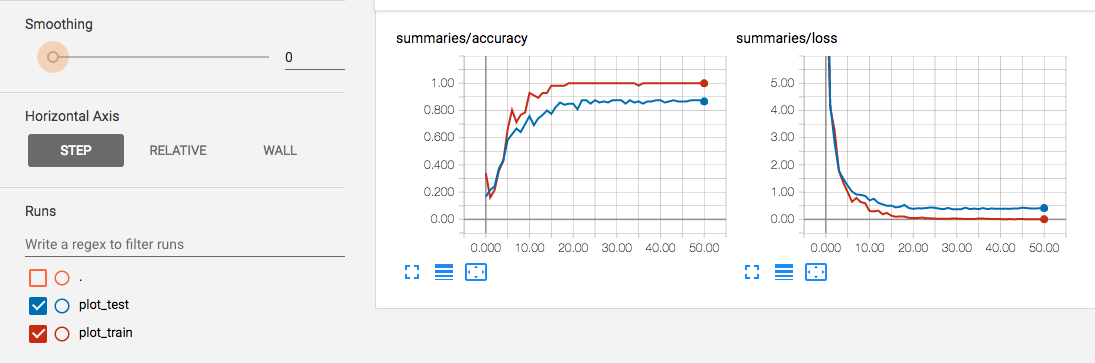

In [147]:
Image(filename='img/overfit_result.png', width=1000)

## Improve to 96.67% by adding dropout layer (keep_prop = 0.6)

In [15]:
model = define_model(lamb=0.0, learning_rate=0.001)
save_path, test_fc = train_model(model, num_epochs=111, minibatch_size=64, dropout_rate=0.6)

Epoch 1/111:
	 train loss: 19.067,	 train accuracy: 15.278 %
	 test loss: 9.181,	 test accuracy: 20.833 %
------------------------------------------------------------
Epoch 6/111:
	 train loss: 3.389,	 train accuracy: 42.037 %
	 test loss: 1.073,	 test accuracy: 63.333 %
------------------------------------------------------------
Epoch 11/111:
	 train loss: 1.160,	 train accuracy: 66.852 %
	 test loss: 0.644,	 test accuracy: 80.833 %
------------------------------------------------------------
Epoch 16/111:
	 train loss: 0.588,	 train accuracy: 81.111 %
	 test loss: 0.418,	 test accuracy: 87.500 %
------------------------------------------------------------
Epoch 21/111:
	 train loss: 0.360,	 train accuracy: 87.593 %
	 test loss: 0.305,	 test accuracy: 89.167 %
------------------------------------------------------------
Epoch 26/111:
	 train loss: 0.254,	 train accuracy: 92.222 %
	 test loss: 0.199,	 test accuracy: 91.667 %
------------------------------------------------------------

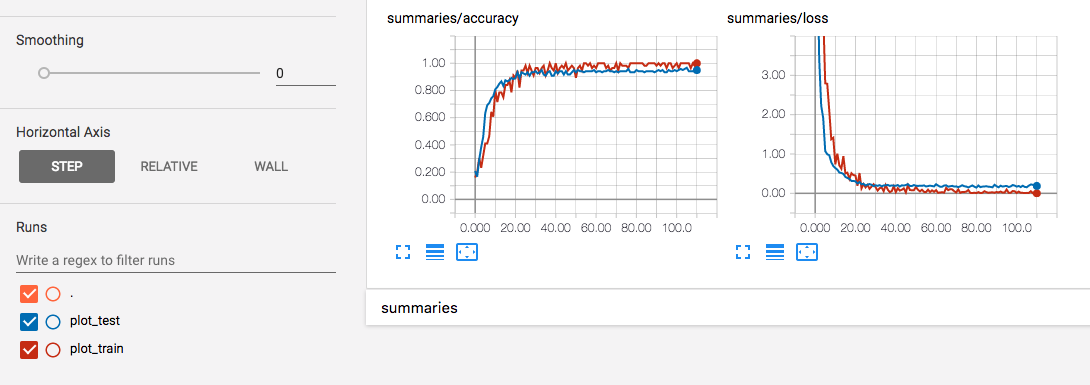

In [149]:
Image(filename='img/dropout_result.png', width=1000)

Display few false predictions

[46 59 61 83]


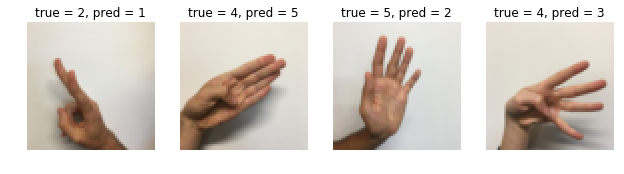

In [45]:
display_false_predicts(test_fc)

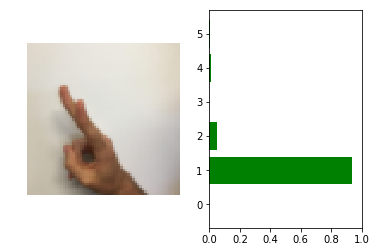

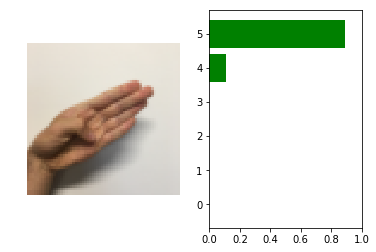

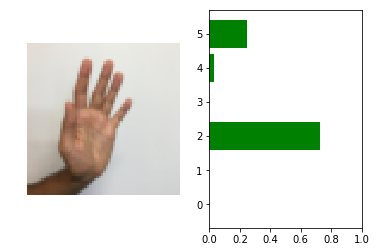

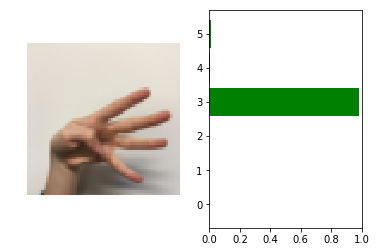

In [59]:
import matplotlib.pyplot as plt
import numpy as np

with tf.Session() as sess:
    sm = tf.nn.softmax(test_fc)
    false = [46, 59, 61, 83]        # index of false predicted images
    plt.figure(figsize=(16,8))
    for i in false:
        p = sess.run(sm)[i,:]         
        fig, ax = plt.subplots()
        class_names = ('0', '1', '2', '3', '4', '5')
        y_pos = np.arange(len(class_names))        
        plt.subplot(1,2,1)
        plt.imshow(X_test[i])
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.barh(y_pos, p, align='center', color='green')
        plt.xlim([0,1])
        plt.yticks([0, 1, 2, 3, 4, 5], class_names)
        plt.show()

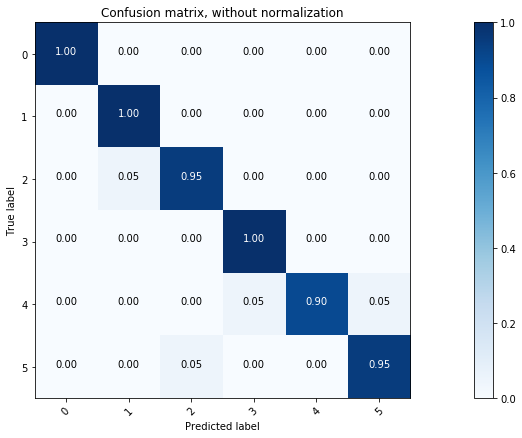

In [167]:
with tf.Session() as sess:
    sm = tf.nn.softmax(test_fc)
    pred = tf.argmax(sm, 1)
    p = sess.run(pred)
    ground_truth = sess.run(tf.argmax(Y_test,1))

class_names = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5'}
# Compute confusion matrix
cnf_matrix = confusion_matrix(ground_truth, p)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(18, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix, without normalization')

### Data augmentation only produces 91.667 % test accuracy

In [151]:
def data_augmentation():
    train_data = []
    train_label = []    
    for i in range(X_train.shape[0]):
        img = X_train[i]
        flip_h = cv2.flip(img, 1)
        flip_v = cv2.flip(img, 0)
        
        M = cv2.getRotationMatrix2D((img.shape[1]/2,img.shape[0]/2),30,1)
        rotate1 = cv2.warpAffine(img,M,(img.shape[1],img.shape[0]))
        
        M = cv2.getRotationMatrix2D((img.shape[1]/2,img.shape[0]/2),-30,1)
        rotate2 = cv2.warpAffine(img,M,(img.shape[1],img.shape[0]))
        
        M = cv2.getRotationMatrix2D((flip_h.shape[1]/2,flip_h.shape[0]/2),30,1)
        rotate3 = cv2.warpAffine(flip_h,M,(flip_h.shape[1],flip_h.shape[0]))
        
        M = cv2.getRotationMatrix2D((flip_h.shape[1]/2,flip_h.shape[0]/2),-30,1)
        rotate4 = cv2.warpAffine(flip_h,M,(flip_h.shape[1],flip_h.shape[0]))
        
        M = cv2.getRotationMatrix2D((flip_v.shape[1]/2,flip_v.shape[0]/2),30,1)
        rotate5 = cv2.warpAffine(flip_v,M,(flip_v.shape[1],flip_v.shape[0]))
        
        M = cv2.getRotationMatrix2D((flip_v.shape[1]/2,flip_v.shape[0]/2),-30,1)
        rotate6 = cv2.warpAffine(flip_v,M,(flip_v.shape[1],flip_v.shape[0]))
        
        train_data.append(img)        
        train_data.append(rotate1)
        train_data.append(rotate2)
        train_data.append(rotate3)
        train_data.append(rotate4)
        train_data.append(rotate5)
        train_data.append(rotate6)
        
        for j in range(7):
            train_label.append(Y_train_orig[0][i])
    
    train_data = np.array(train_data)
    train_label = np.array([train_label])
    return train_data, train_label

In [152]:
train_data, train_label = data_augmentation()
print ('train_data shape:', train_data.shape)
print ('train_label shape:', train_label.shape)

train_data shape: (7560, 64, 64, 3)
train_label shape: (1, 7560)


In [153]:
train_label = train_label.astype(int)
print (train_label[0])

[5 5 5 ..., 5 5 5]


In [154]:
Y_train = train_label
Y_train = convert_to_one_hot(Y_train, 6).T
print ('Y_train shape:', Y_train.shape)

Y_train shape: (7560, 6)


In [155]:
X_train = train_data
print ('X_train shape:', X_train.shape)

X_train shape: (7560, 64, 64, 3)


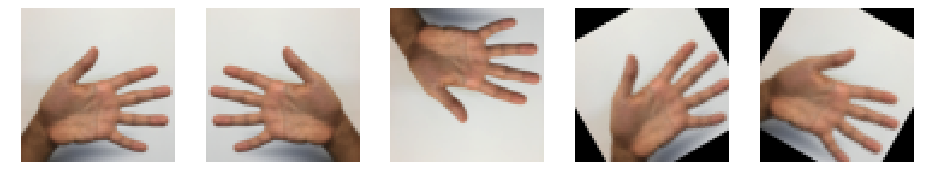

In [3]:
Image(filename='img/augment.png', width=800)

In [156]:
model = define_model(lamb=0.0, learning_rate=0.001)
save_path, test_fc = train_model(model, num_epochs=51, minibatch_size=64)

Epoch 1/51:
	 train loss: 6.275,	 train accuracy: 21.217 %
	 test loss: 2.509,	 test accuracy: 28.333 %
------------------------------------------------------------
Epoch 6/51:
	 train loss: 0.896,	 train accuracy: 66.283 %
	 test loss: 1.003,	 test accuracy: 68.333 %
------------------------------------------------------------
Epoch 11/51:
	 train loss: 0.579,	 train accuracy: 79.206 %
	 test loss: 0.558,	 test accuracy: 76.667 %
------------------------------------------------------------
Epoch 16/51:
	 train loss: 0.447,	 train accuracy: 84.418 %
	 test loss: 0.514,	 test accuracy: 77.500 %
------------------------------------------------------------
Epoch 21/51:
	 train loss: 0.372,	 train accuracy: 86.852 %
	 test loss: 0.437,	 test accuracy: 85.833 %
------------------------------------------------------------
Epoch 26/51:
	 train loss: 0.294,	 train accuracy: 90.093 %
	 test loss: 0.391,	 test accuracy: 85.833 %
------------------------------------------------------------
Epoch 

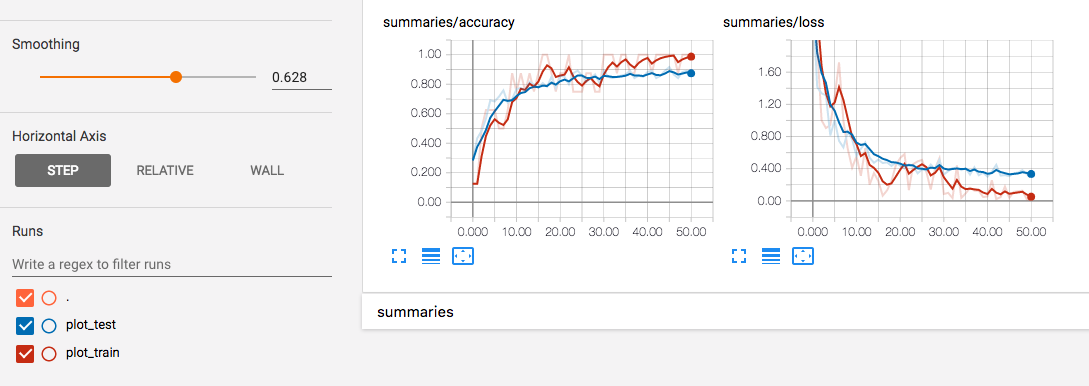

In [160]:
Image(filename='img/data_augment_result.png', width=1000)